In [37]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\glane\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
pwd()

'C:\\Users\\glane'

In [63]:
df = pd.read_excel('datasets/Tweet_NFT.xlsx')   #Read the file

In [64]:
df.head()  #check first 5 rows

,id,tweet_text,tweet_created_at,tweet_intent
0,1212762,@crypto_brody @eCoLoGy1990 @MoonrunnersNFT @It...,2022-08-06T16:56:36.000Z,Community
1,1212763,Need Sick Character artâ“#art #artist #Artist...,2022-08-06T16:56:36.000Z,Giveaway
2,1212765,@The_Hulk_NFT @INagotchiNFT @Tesla @killabears...,2022-08-06T16:56:35.000Z,Appreciation
3,1212766,@CryptoBatzNFT @DarekBTW The first project in ...,2022-08-06T16:56:35.000Z,Community
4,1212767,@sashadysonn The first project in crypto with ...,2022-08-06T16:56:34.000Z,Community


In [65]:
#we require only text and tweet intent column so we drop other columns
df.drop(['id','tweet_created_at'],axis=1,inplace=True)

In [66]:
df.head()

,tweet_text,tweet_intent
0,@crypto_brody @eCoLoGy1990 @MoonrunnersNFT @It...,Community
1,Need Sick Character artâ“#art #artist #Artist...,Giveaway
2,@The_Hulk_NFT @INagotchiNFT @Tesla @killabears...,Appreciation
3,@CryptoBatzNFT @DarekBTW The first project in ...,Community
4,@sashadysonn The first project in crypto with ...,Community


In [67]:
df.isnull().sum()  #check missing values

tweet_text          0
tweet_intent    31089
dtype: int64

In [68]:
df.dropna(inplace=True)   #drop them

<AxesSubplot:>

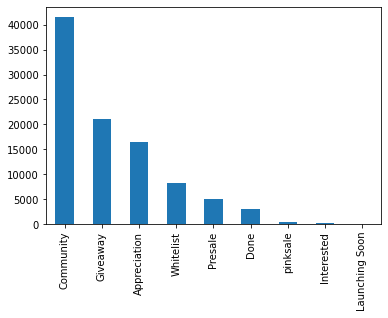

In [69]:
df['tweet_intent'].value_counts().plot(kind='bar')   #this shows the count of each tweet intent

In [76]:
#cleaning tweets
def clean_tweet(tweet):
    tweet = ''.join([c for c in tweet if ord(c) < 128])
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = re.sub('!', "",tweet)
    tweet = re.sub('-', "",tweet)
    tweet = re.sub(':', "",tweet)
    tweet = re.sub('" "', "",tweet)
    tweet = tweet.replace("'", "")
    tweet = tweet.lower()
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet

In [77]:
df['tweet_text'] = df['tweet_text'].map(lambda x: clean_tweet(x))
df

,tweet_text,tweet_intent
0,bowie el a new was born by of the community . ...,Community
1,need sick character artist animation 3danimati...,Giveaway
2,hulk great choice on a good luck,Appreciation
3,the first project in with move to earn . big h...,Community
4,the first project in with move to earn . big h...,Community
...,...,...
96359,0x9fe808d8a9e2e341ea30a8d5ac1e301c32b779fc tha...,Appreciation
96360,just registered to win 1859 with go via,Presale
96361,on the collection theyre and they just yep in ...,Appreciation
96362,join me on discord join me on telegram 6 days ...,Community


### Vectorize tweet_text, by turning each text into either a sequence of integers or into a vector.Limit the data set to the top 50000 words.Set the max number of words in each tweet at 250.

In [83]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweet_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16171 unique tokens.


### Truncate and pad the input sequences so that they are all in the same length for modeling.

In [84]:
X = tokenizer.texts_to_sequences(df['tweet_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (96364, 250)


### Converting categorical labels to numbers.

In [85]:
Y = pd.get_dummies(df['tweet_intent']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (96364, 9)


### Train test split.

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(86727, 250) (86727, 9)
(9637, 250) (9637, 9)


### The first layer is the embedded layer that uses 100 length vectors to represent each word.SpatialDropout1D performs variational dropout in NLP models.The next layer is the LSTM layer with 100 memory units.The output layer must create 13 output values, one for each class.Activation function is softmax for multi-class classification.Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [89]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 9)                 909       
                                                                 
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
1220/1220 [==============================] - 754s 615ms/step - loss: 0.5040 - accuracy: 0.8355 - val_loss: 0.3511 - val_accuracy: 0.8886
Epoch 2/5
1220/1220 [==============================] - 726s 595ms/step - loss: 0.2994 - accuracy: 0.9063 - val_loss: 0.3333 - val_accuracy: 0.8953
Epoch 3/5
1220/1220 [==============================] - 732s 600ms/step - loss: 0.2535 - accuracy: 0.9213 - val_loss: 0.3275 - val_accuracy: 0.8991
Epoch 4/5
1220/1220 [==============================] - 1995s 2s/step - loss: 0.2238 - accuracy: 0.9310 - val_loss: 0.3508 - val_accuracy: 0.8963
Epoch 5/5
1220/1220 [==============================] - 740s 606ms/step - loss: 0.2048 - accuracy: 0.9379 - val_loss: 0.3386 - val_accuracy: 0.9027


In [91]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

302/302 [==============================] - 11s 37ms/step - loss: 0.3256 - accuracy: 0.9024
Test set
  Loss: 0.326
  Accuracy: 0.902


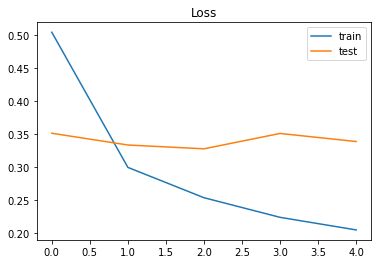

In [92]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

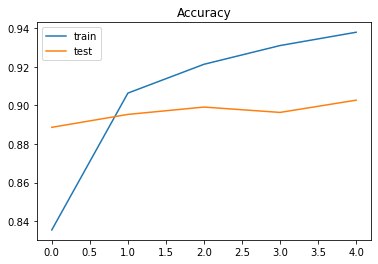

In [97]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### The plots suggest that the model has a little over fitting problem, more data may help, but more epochs will not help using the current data.